# 📊 UPI Transaction Analysis

This notebook helps you analyze and visualize your UPI transactions from Google Pay and Paytm. Follow along to gain insights into your spending patterns!

## Setup Instructions

1. Upload your Google Pay activity file (`My Activity.html`)
2. Upload your Paytm transaction file (`.xlsx`)
3. Run the cells in order

Let's get started! 🚀

## Install Required Packages

First, let's install the necessary Python packages.

In [1]:
!pip install pandas numpy matplotlib seaborn beautifulsoup4 openpyxl


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Import Libraries

Now let's import all the required libraries for our analysis.

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import re
from datetime import datetime
import os

# Set style for better visualizations
plt.style.use('default')  # Reset to default style first
sns.set_theme()  # Apply seaborn theme
sns.set_palette('pastel')  # Set color palette

## Google Pay Data Processing

Let's start by processing the Google Pay transaction data from the HTML file.

Make sure your `My Activity.html` file is in the same directory as this notebook.

In [38]:
# Local file path for Google Pay data
html_file_path = 'My Activity.html'
print(f"Processing Google Pay data from: {html_file_path}")

Processing Google Pay data from: My Activity.html


In [48]:
def process_gpay_data(html_file_path):
    # Read HTML content with proper encoding handling
    html_content = None
    encodings_to_try = ['utf-8', 'latin-1', 'cp1252']
    for enc in encodings_to_try:
        try:
            with open(html_file_path, 'r', encoding=enc) as f:
                html_content = f.read()
            break
        except UnicodeDecodeError:
            continue
    
    if not html_content:
        raise ValueError("Could not read the HTML file with any supported encoding")
    
    # Parse HTML
    soup = BeautifulSoup(html_content, 'html.parser')
    transaction_blocks = soup.find_all('div', class_='outer-cell mdl-cell mdl-cell--12-col mdl-shadow--2dp')
    
    extracted_data = []
    
    for block in transaction_blocks:
        data = {
            'Title': None,
            'Status': None,
            'Amount': None,
            'Recipent/Sender Info': None,
            'Payment Method': None,
            'Date': None,
            'Time': None
        }
        
        # Extract title
        title_tag = block.find('p', class_='mdl-typography--title')
        if title_tag:
            data['Title'] = title_tag.get_text(strip=True)
        
        # Find content cell within inner grid
        content_cell = block.find('div', class_='content-cell mdl-cell mdl-cell--6-col mdl-typography--body-1')
        if content_cell:
            lines = [text for text in content_cell.stripped_strings]
            if lines:
                # Parse main transaction line
                main_line = lines[0]
                match_base = re.match(
                    r'^(Paid|Sent|Received)\s+'             # Status
                    r'(₹[\d,]+\.\d{2,})\s*'                # Amount
                    r'(.*)$',                               # Rest of the line
                    main_line,
                    re.IGNORECASE | re.DOTALL
                )
                
                if match_base:
                    data['Status'] = match_base.group(1).capitalize()
                    data['Amount'] = match_base.group(2)
                    remainder = match_base.group(3).strip()
                    
                    # Parse recipient and payment method
                    recipient_info = None
                    payment_method = None
                    
                    using_match = re.search(r'\susing\s+(.*)$', remainder, re.IGNORECASE)
                    if using_match:
                        payment_method = f"using {using_match.group(1).strip()}"
                        potential_recipient = remainder[:using_match.start()].strip()
                        
                        if potential_recipient.lower().startswith('to ') or potential_recipient.lower().startswith('from '):
                            prefix_lower = potential_recipient[:potential_recipient.find(' ')+1].lower()
                            status_lower = data['Status'].lower()
                            if (status_lower in ['paid', 'sent'] and prefix_lower == 'to ') or \
                               (status_lower == 'received' and prefix_lower == 'from '):
                                recipient_info = potential_recipient
                        elif potential_recipient:
                            prefix = 'to' if data['Status'] in ['Paid', 'Sent'] else 'from'
                            recipient_info = f"{prefix} {potential_recipient}"
                    else:
                        potential_recipient = remainder
                        if potential_recipient:
                            if potential_recipient.lower().startswith('to ') or potential_recipient.lower().startswith('from '):
                                prefix_lower = potential_recipient[:potential_recipient.find(' ')+1].lower()
                                status_lower = data['Status'].lower()
                                if (status_lower in ['paid', 'sent'] and prefix_lower == 'to ') or \
                                   (status_lower == 'received' and prefix_lower == 'from '):
                                    recipient_info = potential_recipient
                            else:
                                prefix = 'to' if data['Status'] in ['Paid', 'Sent'] else 'from'
                                recipient_info = f"{prefix} {potential_recipient}"
                    
                    data['Recipent/Sender Info'] = recipient_info
                    data['Payment Method'] = payment_method
                
                # Parse date and time
                if len(lines) >= 2:
                    date_time_line = lines[1]
                    parts = date_time_line.split(',')
                    if len(parts) >= 3:
                        data['Date'] = f"{parts[0].strip()} {parts[1].strip()}"
                        time_part_str = parts[2].strip()
                        time_match = re.search(r'(\d{1,2}:\d{2}:\d{2}(\s*|\u202f)[AP]M)', time_part_str)
                        if time_match:
                            time_str = time_match.group(1)
                            time_str = time_str.replace('\u202f', ' ').replace(' ', ' ').strip()
                            time_str = re.sub(r'\s+', ' ', time_str)
                            data['Time'] = time_str
        
        extracted_data.append(data)
    
    # Create DataFrame and clean data
    df = pd.DataFrame(extracted_data)
    if not df.empty:
        # Reorder columns
        df = df[['Title', 'Status', 'Amount', 'Recipent/Sender Info', 'Payment Method', 'Date', 'Time']]
        
        # Data Cleansing
        empty_both = df['Recipent/Sender Info'].isna() & df['Payment Method'].isna()
        status_sent_paid = df['Status'].isin(['Sent', 'Paid'])
        status_received = df['Status'] == 'Received'
        
        # Update missing Recipient/Sender Info
        df.loc[empty_both & status_sent_paid, 'Recipent/Sender Info'] = 'to Unknown'
        df.loc[empty_both & status_received, 'Recipent/Sender Info'] = 'from Unknown'
        
        # Update missing Payment Method
        df.loc[empty_both, 'Payment Method'] = 'Unknown'
        df.loc[df['Payment Method'].isna(), 'Payment Method'] = 'Unknown'
        
        # Fix misaligned bank account information
        bank_account_mask = df['Recipent/Sender Info'].str.contains('to using Bank Account', na=False)
        for idx in df[bank_account_mask].index:
            recipient_value = df.loc[idx, 'Recipent/Sender Info']
            payment_method = recipient_value.replace('to ', '', 1)
            df.loc[idx, 'Payment Method'] = payment_method
            df.loc[idx, 'Recipent/Sender Info'] = 'to Unknown'
    
    return df

# Process Google Pay data
gpay_df = process_gpay_data(html_file_path)
print("Google Pay transactions processed successfully!")
gpay_df.head()

Google Pay transactions processed successfully!


,Title,Status,Amount,Recipent/Sender Info,Payment Method,Date,Time
0,Google Pay,Paid,₹10.00,to Cash and carry departmental store,using Bank Account XXXXXX0572,Apr 9 2025,9:22:11 PM
1,Google Pay,Paid,₹20.00,to CASH AND CARRY DEPARTMENTAL STORE,using Bank Account XXXXXX0572,Apr 9 2025,9:21:37 PM
2,Google Pay,Sent,₹80.00,to Unknown,using Bank Account XXXXXX0572,Apr 8 2025,4:55:28 PM
3,Google Pay,Paid,₹2.00,to NEHA DHIMAN,using Bank Account XXXXXX0572,Apr 8 2025,1:16:53 PM
4,Google Pay,Paid,₹20.00,to SINGHS THE BAKERS FOOD COURT,using Bank Account XXXXXX0572,Apr 6 2025,7:05:07 PM


## Paytm Data Processing

Now, let's process the Paytm transaction data. Make sure your Paytm `.xlsx` file is in the same directory as this notebook.
We'll be reading from the 'Passbook Payment History' sheet.

In [40]:
# Local file path for Paytm data
paytm_file_path = 'paytm.xlsx'
sheet_name = 'Passbook Payment History'
comment_to_remove = "This is not included in total paid and received calculations."
print(f"Processing Paytm data from: {paytm_file_path}, sheet: {sheet_name}")

Processing Paytm data from: paytm.xlsx, sheet: Passbook Payment History


In [49]:
def process_paytm_data(excel_file_path, sheet_name):
    # Read Paytm Excel file
    df = pd.read_excel(excel_file_path, sheet_name=sheet_name, dtype=str)
    
    # Initial cleanup
    df = df.map(lambda x: x.strip() if isinstance(x, str) else x)
    
    # Rename columns for consistency
    rename_map = {
        'Transaction Details': 'Recipent/Sender Info',
        'Your Account': 'Payment Method'
    }
    df.rename(columns=rename_map, inplace=True)
    
    # Drop non-essential columns
    cols_to_drop = ['UPI Ref No.', 'Order ID', 'Remarks', 'Tags']
    existing_cols_to_drop = [col for col in cols_to_drop if col in df.columns]
    if existing_cols_to_drop:
        df.drop(columns=existing_cols_to_drop, inplace=True)
    
    # Filter rows based on Comment
    if 'Comment' in df.columns:
        df['Comment'] = df['Comment'].astype(str).fillna('')
        df = df[df['Comment'] != comment_to_remove].copy()
        if 'Comment' in df.columns:
            df.drop(columns=['Comment'], inplace=True)
    
    # Add Title column
    df['Title'] = 'Paytm'
    
    # Process Amount and create Status
    if 'Amount' in df.columns:
        original_amount_str = df['Amount'].astype(str).copy()
        df['Numeric_Amount'] = df['Amount'].str.replace(r'[+,"]', '', regex=True).str.strip()
        df['Numeric_Amount'] = pd.to_numeric(df['Numeric_Amount'], errors='coerce')
        
        # Create Status
        df['Status'] = 'Unknown'
        df.loc[df['Numeric_Amount'] >= 0, 'Status'] = 'Received'
        df.loc[df['Numeric_Amount'] < 0, 'Status'] = 'Paid'
        
        # Format Amount
        df.loc[df['Numeric_Amount'].notna(), 'Amount'] = df.loc[df['Numeric_Amount'].notna(), 'Numeric_Amount'].abs().map('₹{:.2f}'.format)
        df.drop(columns=['Numeric_Amount'], inplace=True)
    
    # Format Date and Time
    if 'Date' in df.columns:
        # Convert DD/MM/YYYY to datetime with explicit format
        df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y', errors='coerce')
        df['Date'] = df['Date'].dt.strftime('%b %d %Y')
    
    if 'Time' in df.columns:
        df['Time'] = pd.to_datetime(df['Time'], format='%I:%M:%S %p', errors='coerce').dt.strftime('%I:%M:%S %p')
        df['Time'] = df['Time'].str.replace('^0', '', regex=True)  # Remove leading zeros
    
    # Reorder columns
    columns_order = ['Title', 'Status', 'Amount', 'Recipent/Sender Info', 'Payment Method', 'Date', 'Time']
    df = df[columns_order]
    
    return df

# Process Paytm data
paytm_df = process_paytm_data(paytm_file_path, sheet_name)
print("Paytm transactions processed successfully!")
paytm_df.head()

Paytm transactions processed successfully!


d:\Gpay\myenv\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,Title,Status,Amount,Recipent/Sender Info,Payment Method,Date,Time
0,Paytm,Paid,₹391.00,Paid to Blinkit,Jammu and Kashmir Bank - 0572,Apr 06 2025,NaN
1,Paytm,Received,₹2000.00,Received from Hridoy Barua,Jammu and Kashmir Bank - 0572,Apr 01 2025,NaN
2,Paytm,Received,₹50.00,Received from One Ninety Seven,Jammu and Kashmir Bank - 0572,Mar 08 2025,NaN
3,Paytm,Paid,₹100.00,Money sent to Ali Elsayed Abakar Eldago,Jammu and Kashmir Bank - 0572,Mar 06 2025,NaN
4,Paytm,Received,₹50.00,Received from One Ninety Seven,Jammu and Kashmir Bank - 0572,Mar 06 2025,NaN


## Combine and Clean Data

Let's combine both datasets and prepare them for analysis.

In [50]:
def prepare_combined_data(gpay_df, paytm_df):
    # Combine dataframes
    df = pd.concat([gpay_df, paytm_df], ignore_index=True)
    
    # Clean amount values
    df['Amount'] = df['Amount'].str.replace('₹', '').str.replace(',', '').astype(float)
    
    # Convert date to datetime - handle both formats (with and without commas)
    def parse_date(date_str):
        try:
            # Try parsing as "MMM DD YYYY" format (Paytm format)
            return pd.to_datetime(date_str, format='%b %d %Y')
        except:
            try:
                # Try parsing as "MMM DD, YYYY" format (Google Pay format)
                return pd.to_datetime(date_str, format='%b %d, %Y')
            except:
                return pd.NaT
    
    df['Date'] = df['Date'].apply(parse_date)
    
    # Add useful columns for analysis
    df['Month'] = df['Date'].dt.strftime('%Y-%m')
    df['DayOfWeek'] = df['Date'].dt.day_name()
    
    # Payment Method standardization
    # Create conditions for each bank based on account numbers
    mask_0572 = df['Payment Method'].str.contains('0572', na=False)
    mask_1552 = df['Payment Method'].str.contains('1552', na=False)
    
    # Apply standardized names
    df.loc[mask_0572, 'Payment Method'] = 'Jammu and Kashmir Bank - 0572'
    df.loc[mask_1552, 'Payment Method'] = 'State Bank Of India - 1552'
    
    return df

# Combine and prepare data
combined_df = prepare_combined_data(gpay_df, paytm_df)
print("Data combined and prepared successfully!")
combined_df.head()

Data combined and prepared successfully!


,Title,Status,Amount,Recipent/Sender Info,Payment Method,Date,Time,Month,DayOfWeek
0,Google Pay,Paid,10.0,to Cash and carry departmental store,Jammu and Kashmir Bank - 0572,2025-04-09,9:22:11 PM,2025-04,Wednesday
1,Google Pay,Paid,20.0,to CASH AND CARRY DEPARTMENTAL STORE,Jammu and Kashmir Bank - 0572,2025-04-09,9:21:37 PM,2025-04,Wednesday
2,Google Pay,Sent,80.0,to Unknown,Jammu and Kashmir Bank - 0572,2025-04-08,4:55:28 PM,2025-04,Tuesday
3,Google Pay,Paid,2.0,to NEHA DHIMAN,Jammu and Kashmir Bank - 0572,2025-04-08,1:16:53 PM,2025-04,Tuesday
4,Google Pay,Paid,20.0,to SINGHS THE BAKERS FOOD COURT,Jammu and Kashmir Bank - 0572,2025-04-06,7:05:07 PM,2025-04,Sunday


## Transaction Analysis and Visualization

Let's create detailed visualizations of your transaction data.

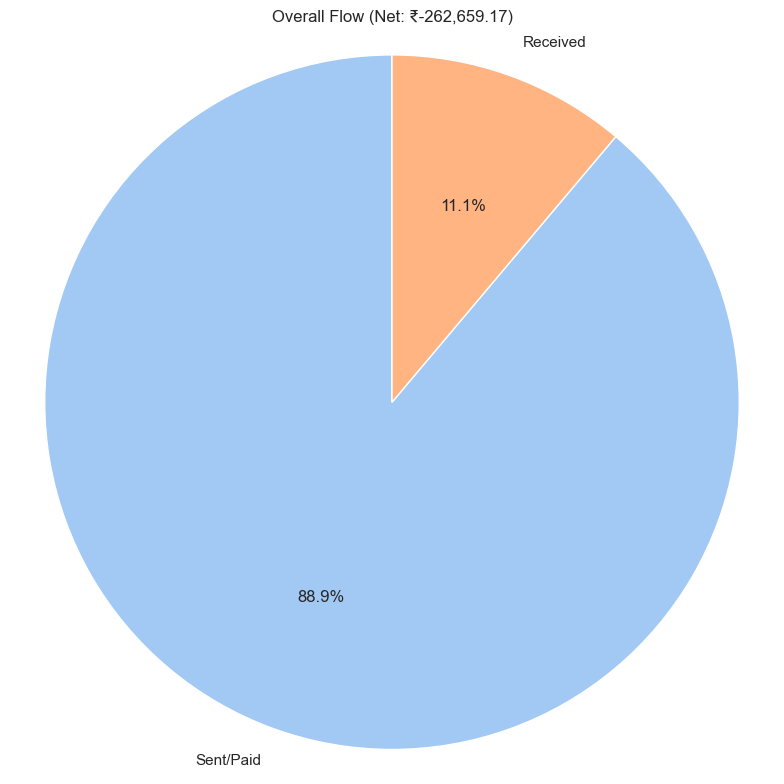

C:\Users\Raj Kapoor\AppData\Local\Temp\ipykernel_9364\241187600.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=categories, y=values, ax=ax, palette="pastel")


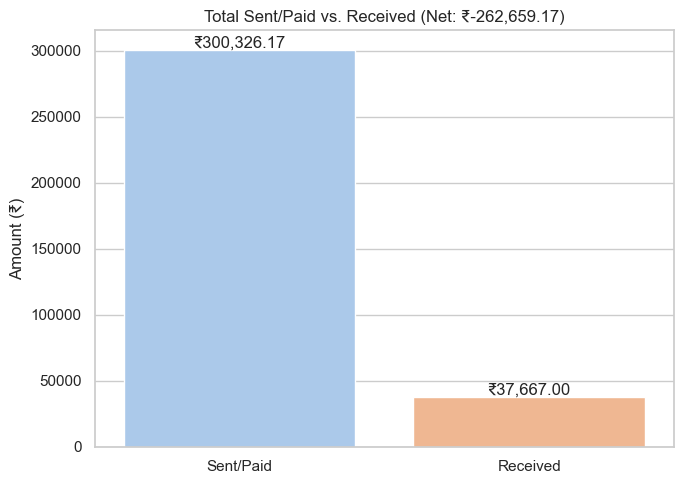

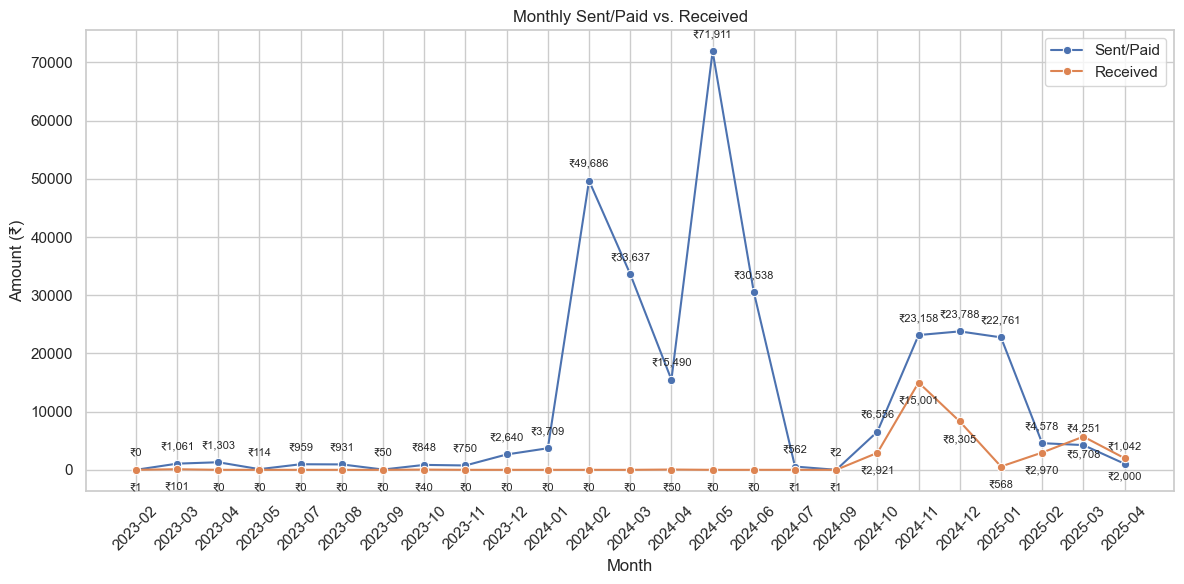

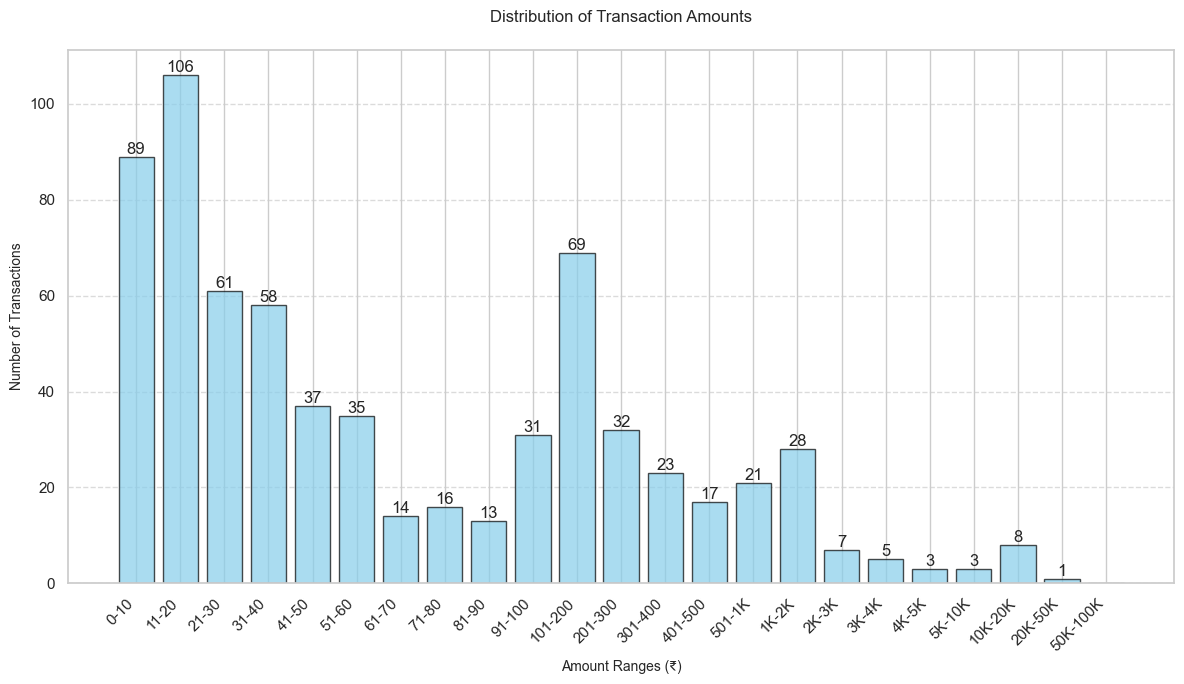

C:\Users\Raj Kapoor\AppData\Local\Temp\ipykernel_9364\241187600.py:156: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(y=top_recipients.index, x=top_recipients.values,


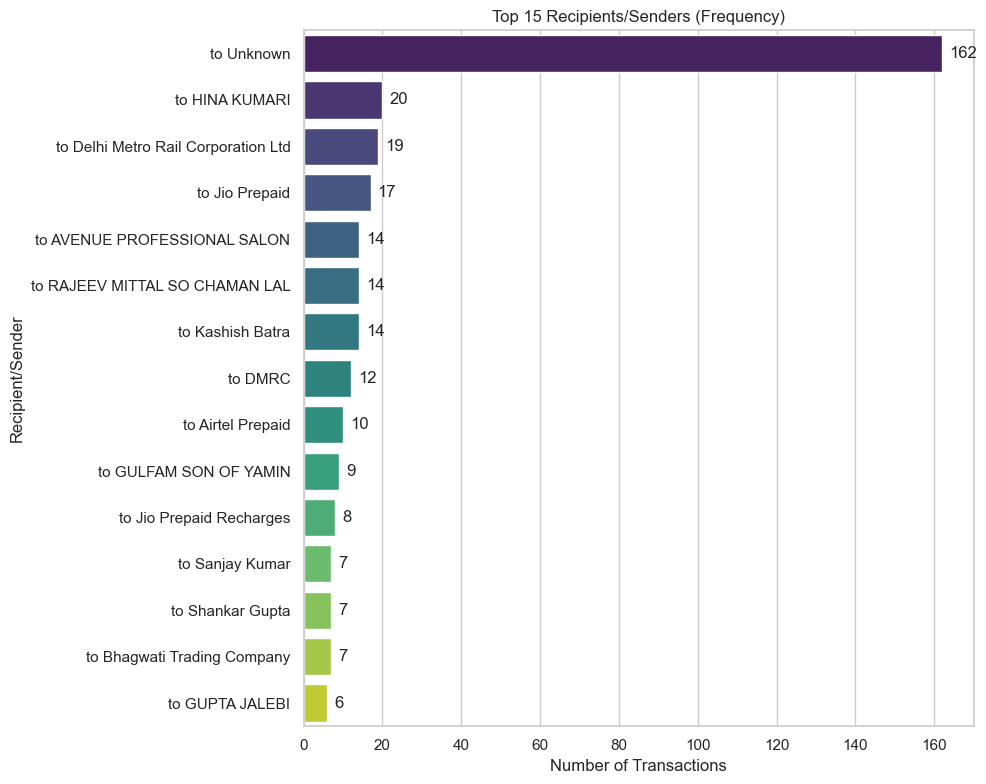

C:\Users\Raj Kapoor\AppData\Local\Temp\ipykernel_9364\241187600.py:180: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(y=payment_method_counts.index, x=payment_method_counts.values,


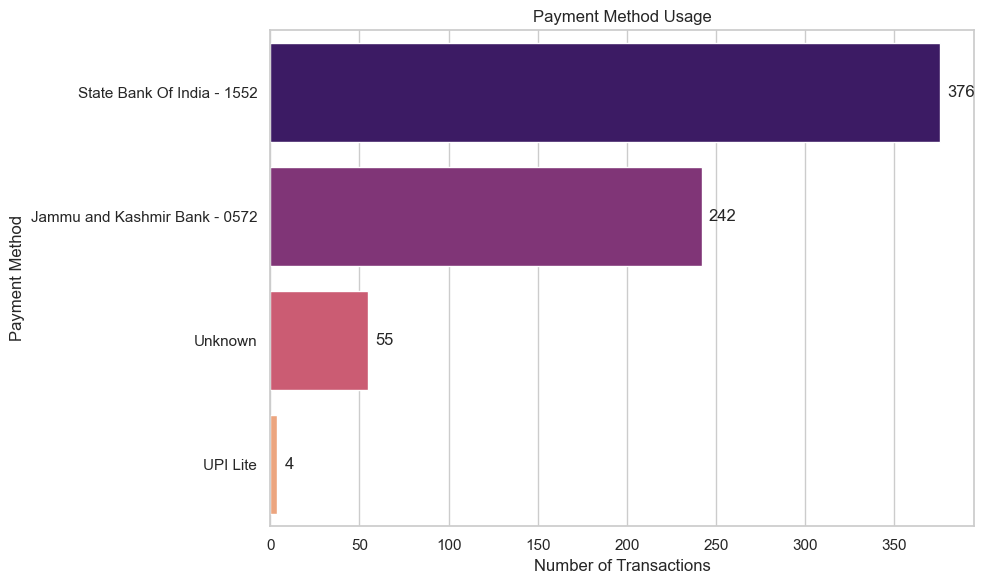

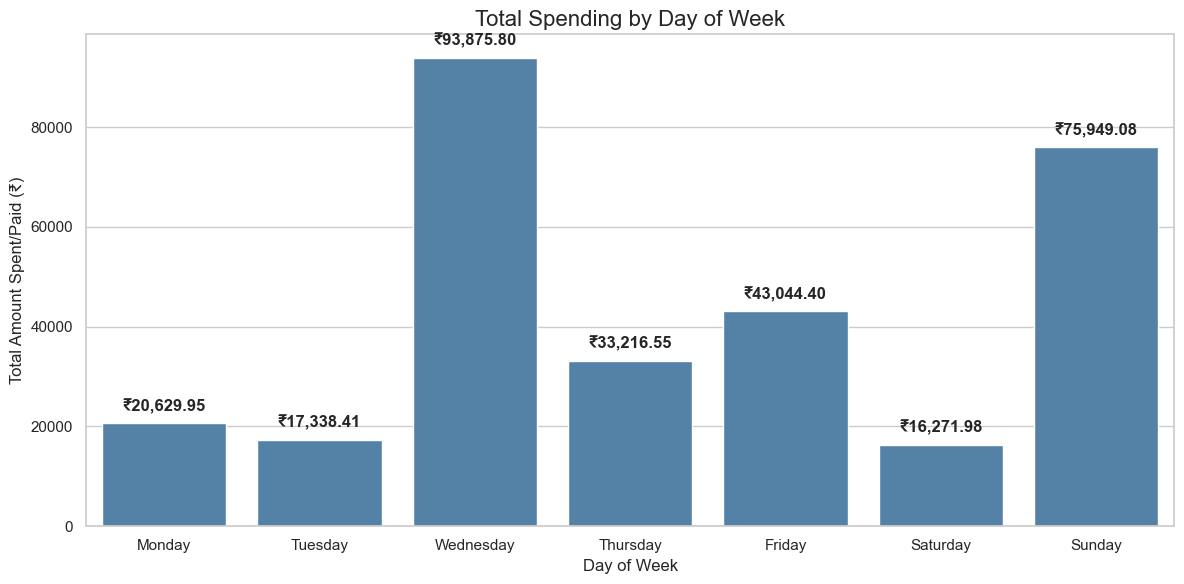

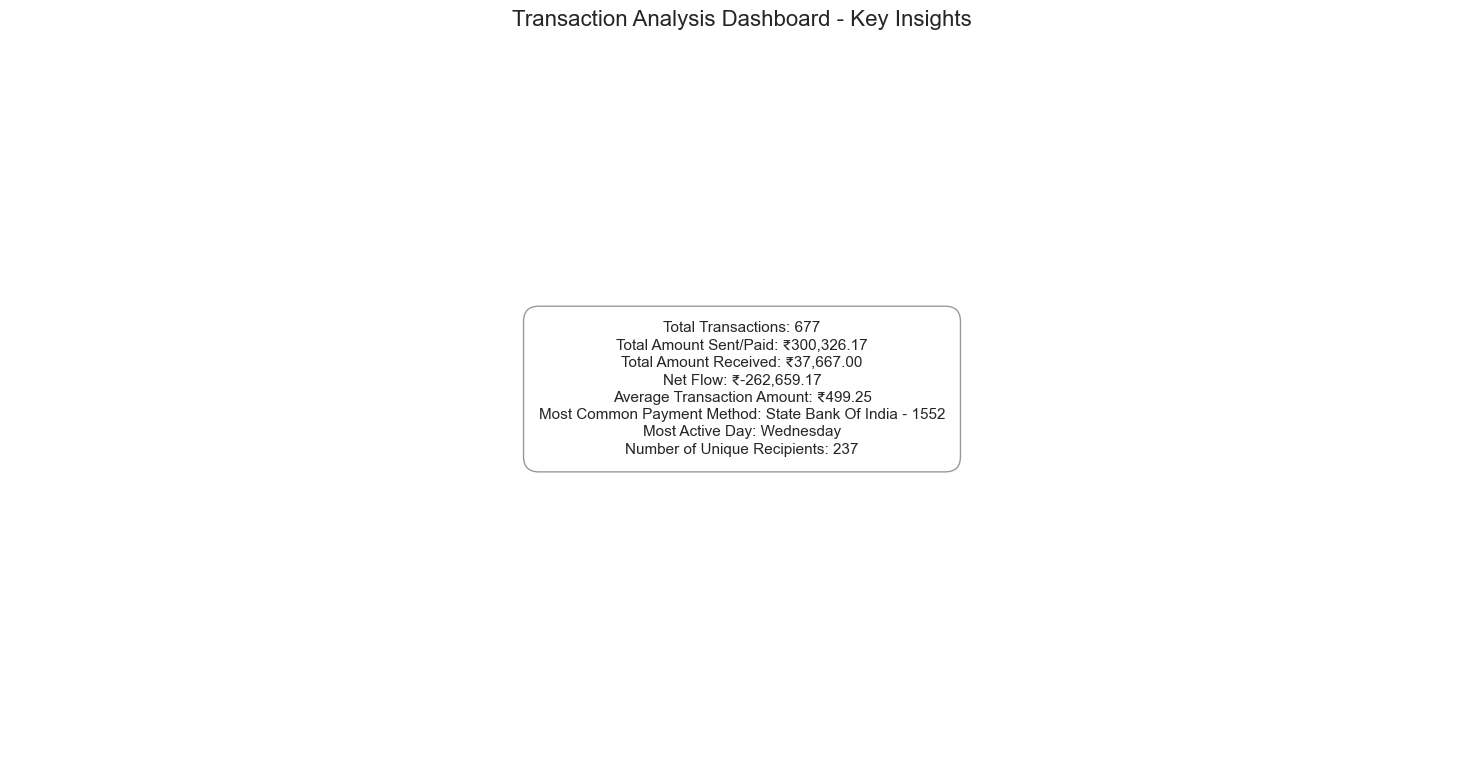

All visualizations have been displayed in the notebook.


In [55]:
def plot_transaction_analysis(df):
    # Set style
    sns.set_theme(style="whitegrid")
    
    # Prepare data
    sent_paid_df = df[df['Status'].isin(['Sent', 'Paid'])]
    received_df = df[df['Status'] == 'Received']
    
    total_sent_paid = sent_paid_df['Amount'].sum()
    total_received = received_df['Amount'].sum()
    net_flow = total_received - total_sent_paid
    
    # 1. Overall Flow - Pie Chart
    plt.figure(figsize=(8, 8))
    ax = plt.gca()
    if total_sent_paid > 0 or total_received > 0:
        ax.pie(
            [total_sent_paid, total_received],
            labels=['Sent/Paid', 'Received'],
            autopct='%1.1f%%',
            startangle=90,
            colors=sns.color_palette("pastel")[0:2]
        )
        ax.set_title(f'Overall Flow (Net: ₹{net_flow:,.2f})')
    else:
        ax.text(0.5, 0.5, 'No Transaction Data', ha='center', va='center')
        ax.set_title('Overall Flow')
    ax.axis('equal')
    plt.tight_layout()
    plt.show()
    
    # 2. Overall Flow - Bar Chart
    plt.figure(figsize=(7, 5))
    ax = plt.gca()
    categories = ['Sent/Paid', 'Received']
    values = [total_sent_paid, total_received]
    bars = sns.barplot(x=categories, y=values, ax=ax, palette="pastel")
    ax.set_title(f'Total Sent/Paid vs. Received (Net: ₹{net_flow:,.2f})')
    ax.set_ylabel('Amount (₹)')
    for bar in bars.patches:
        ax.annotate(f'₹{bar.get_height():,.2f}',
                    (bar.get_x() + bar.get_width() / 2., bar.get_height()),
                    ha='center', va='center',
                    xytext=(0, 5),
                    textcoords='offset points')
    plt.tight_layout()
    plt.show()
    
    # 3. Monthly Trends
    plt.figure(figsize=(12, 6))
    
    # Fix monthly aggregation by calculating sent/paid and received separately
    monthly_sent_paid = sent_paid_df.groupby('Month')['Amount'].sum()
    monthly_received = received_df.groupby('Month')['Amount'].sum()
    
    # Create monthly summary DataFrame
    monthly_summary = pd.DataFrame({
        'MonthStr': sorted(set(monthly_sent_paid.index) | set(monthly_received.index)),
        'TotalSentPaid': [monthly_sent_paid.get(m, 0) for m in sorted(set(monthly_sent_paid.index) | set(monthly_received.index))],
        'TotalReceived': [monthly_received.get(m, 0) for m in sorted(set(monthly_sent_paid.index) | set(monthly_received.index))]
    })
    
    ax = plt.gca()
    if not monthly_summary.empty:
        sent_line = sns.lineplot(data=monthly_summary, x='MonthStr', y='TotalSentPaid', 
                                marker='o', label='Sent/Paid', ax=ax)
        received_line = sns.lineplot(data=monthly_summary, x='MonthStr', y='TotalReceived', 
                                    marker='o', label='Received', ax=ax)
        
        # Add value labels
        for idx, row in monthly_summary.iterrows():
            if pd.notna(row['TotalSentPaid']):
                ax.annotate(f'₹{row["TotalSentPaid"]:,.0f}',
                           (idx, row['TotalSentPaid']),
                           textcoords="offset points",
                           xytext=(0,10),
                           ha='center',
                           fontsize=8)
            if pd.notna(row['TotalReceived']):
                ax.annotate(f'₹{row["TotalReceived"]:,.0f}',
                           (idx, row['TotalReceived']),
                           textcoords="offset points",
                           xytext=(0,-15),
                           ha='center',
                           fontsize=8)
        
        ax.set_title('Monthly Sent/Paid vs. Received')
        ax.set_xlabel('Month')
        ax.set_ylabel('Amount (₹)')
        ax.tick_params(axis='x', rotation=45)
        ax.legend()
    else:
        ax.text(0.5, 0.5, 'No Monthly Data', ha='center', va='center')
        ax.set_title('Monthly Sent/Paid vs. Received')
    plt.tight_layout()
    plt.show()
    
    # 4. Transaction Distribution
    plt.figure(figsize=(12, 7))
    ax = plt.gca()
    
    if not df.empty:
        # Define bin edges and labels
        bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 
                200, 300, 400, 500, 1000, 2000, 3000, 4000, 5000, 
                10000, 20000, 50000, 100000]
        labels = ['0-10', '11-20', '21-30', '31-40', '41-50', 
                 '51-60', '61-70', '71-80', '81-90', '91-100',
                 '101-200', '201-300', '301-400', '401-500',
                 '501-1K', '1K-2K', '2K-3K', '3K-4K', '4K-5K',
                 '5K-10K', '10K-20K', '20K-50K', '50K-100K']
        
        # Apply binning with right=True to include upper edge
        df['AmountBin'] = pd.cut(df['Amount'], bins=bins, labels=labels, right=True)
        
        # Count occurrences in each bin
        counts = df['AmountBin'].value_counts().reindex(labels, fill_value=0)
        
        # Create bar plot with counts
        bars = ax.bar(range(len(labels)), counts.values, 
                     color='skyblue', alpha=0.7,
                     edgecolor='black', linewidth=1)
        
        # Customize the plot
        ax.set_title('Distribution of Transaction Amounts', fontsize=12, pad=20)
        ax.set_xlabel('Amount Ranges (₹)', fontsize=10)
        ax.set_ylabel('Number of Transactions', fontsize=10)
        
        # Set x-axis labels
        ax.set_xticks(range(len(labels)))
        ax.set_xticklabels(labels, rotation=45, ha='right')
        
        # Add value labels on top of each bar
        for bar in bars:
            height = bar.get_height()
            if height > 0:  # Only show label if there are transactions in that range
                ax.text(bar.get_x() + bar.get_width()/2., height,
                        f'{int(height)}',
                        ha='center', va='bottom')
        
        # Add grid for better readability
        ax.yaxis.grid(True, linestyle='--', alpha=0.7)
        ax.set_axisbelow(True)
    else:
        ax.text(0.5, 0.5, 'No Transaction Data', ha='center', va='center')
    
    plt.tight_layout()
    plt.show()
    
    # 5. Top Recipients
    plt.figure(figsize=(10, 8))
    ax = plt.gca()
    top_recipients = sent_paid_df['Recipent/Sender Info'].value_counts().head(15)
    
    if not top_recipients.empty:
        bars = sns.barplot(y=top_recipients.index, x=top_recipients.values, 
                          ax=ax, palette="viridis", orient='h')
        ax.set_title('Top 15 Recipients/Senders (Frequency)')
        ax.set_xlabel('Number of Transactions')
        ax.set_ylabel('Recipient/Sender')
        
        for bar in bars.patches:
            ax.annotate(f'{int(bar.get_width())}',
                        (bar.get_width(), bar.get_y() + bar.get_height() / 2.),
                        ha='left', va='center',
                        xytext=(5, 0),
                        textcoords='offset points')
    else:
        ax.text(0.5, 0.5, 'No Recipient Data', ha='center', va='center')
    
    plt.tight_layout()
    plt.show()
    
    # 6. Payment Methods
    plt.figure(figsize=(10, 6))
    ax = plt.gca()
    payment_method_counts = df['Payment Method'].value_counts()
    
    if not payment_method_counts.empty:
        bars = sns.barplot(y=payment_method_counts.index, x=payment_method_counts.values, 
                          ax=ax, palette="magma", orient='h')
        ax.set_title('Payment Method Usage')
        ax.set_xlabel('Number of Transactions')
        ax.set_ylabel('Payment Method')
        
        for bar in bars.patches:
            ax.annotate(f'{int(bar.get_width())}',
                        (bar.get_width(), bar.get_y() + bar.get_height() / 2.),
                        ha='left', va='center',
                        xytext=(5, 0),
                        textcoords='offset points')
    else:
        ax.text(0.5, 0.5, 'No Payment Method Data', ha='center', va='center')
    
    plt.tight_layout()
    plt.show()
    
    # 7. Daily Spending with improved visualization
    plt.figure(figsize=(12, 6))
    
    # Create weekday summary with proper ordering
    weekday_summary = sent_paid_df.groupby('DayOfWeek')['Amount'].sum().reindex([
        'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
    ])
    
    # Create plot with seaborn
    ax = sns.barplot(x=weekday_summary.index, y=weekday_summary.values, color='steelblue')
    
    # Add value labels with improved formatting
    for i, val in enumerate(weekday_summary.values):
        ax.text(i, val + (weekday_summary.max() * 0.02), # Dynamic offset based on data
                f'₹{val:,.2f}', 
                ha='center', 
                va='bottom', 
                fontweight='bold')
    
    plt.title('Total Spending by Day of Week', fontsize=16)
    plt.xlabel('Day of Week')
    plt.ylabel('Total Amount Spent/Paid (₹)')
    plt.tight_layout()
    plt.show()

        
    # 8. Insights Dashboard
    plt.figure(figsize=(15, 8))
    plt.suptitle('Transaction Analysis Dashboard - Key Insights', fontsize=16, y=0.95)
    
    # Calculate insights
    insights = [
        f"Total Transactions: {len(df):,}",
        f"Total Amount Sent/Paid: ₹{total_sent_paid:,.2f}",
        f"Total Amount Received: ₹{total_received:,.2f}",
        f"Net Flow: ₹{net_flow:,.2f}",
        f"Average Transaction Amount: ₹{df['Amount'].mean():,.2f}",
        f"Most Common Payment Method: {payment_method_counts.index[0]}",
        f"Most Active Day: {weekday_summary.idxmax()}",
        f"Number of Unique Recipients: {sent_paid_df['Recipent/Sender Info'].nunique():,}"
    ]
    
    plt.text(0.5, 0.5, '\n'.join(insights),
             ha='center', va='center',
             bbox=dict(facecolor='white', alpha=0.8, 
                      edgecolor='gray', boxstyle='round,pad=1'),
             fontsize=11,
             linespacing=1.3,
             family='Arial')
    
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Generate all visualizations
plot_transaction_analysis(combined_df)
print("All visualizations have been displayed in the notebook.")